# Most popular placenames per country




## 1. Preprocessing

The aim of preprocessing is to do heavy processing using robust "C-level" tools: from the 60GB planet data and 35 million named highways get reasonable data sizes to be processed via python. I use:
* **wget** to download per-country osm.pbf files from download.geofabrik.de - so I don't need to worry how to 'reverse-geocode' the 35M roads
* **osmconvert** to get faster to be processed o5m format files 
* **osmfilter** to get top 'name' tag values for every country

### Preprocessing steps

1. Scrape lists of `*.pbf` file URLS from the download.geofabrik.de page, one per continent, and used wget to download the files: `wget -c -nc -i europe.txt` . This ended up with ~100 GB of downloads, and is the slowest step. Not only depending on your network, as the server also does not like such mass downloads and you need to wait between them. It took me few days. My apologises to Geofabrik!
2. Convert all downloads to .o5m format using [osmconvert](https://wiki.openstreetmap.org/wiki/Osmconvert), as suggested by osmfilter. This will take up to a couple of minutes per big (over 1GB) country, just a moment for smaller ones.  Warning: the **resulting .o5m file is 2-3 times bigger than .pbf**, so make sure you have enough free storage space. Of course you can combine next 2 steps and delete the data files immediately after processing, but I like to keep it to be able to re-process later. Also it helps to "divide and conquer": split tasks to continents (or more). 
```bash
#!/bin/bash
FILES=*.pbf
for f in $FILES
do
  echo "Processing $f file..."
  ../osmconvert  $f -o=$f.o5m
done
```
3. Use [osmfilter](https://wiki.openstreetmap.org/wiki/Osmfilter) tool to get top tag "name" values, and then use shell utils `sort` and `head` to get the most popular names. Tag stats is not the main purpose of the tool, but any other method to get the tops is really heavy. It is also quite fast, takes also up to couple of minutes for the biggest countries. Unfortunately the tool does not do filtering and stats in one step, so the resulting name values includes all objects, like POI names, as you see in some countries. Usually still the street/road name is in the top. 

```bash
#!/bin/bash
FILES=*.o5m
for f in $FILES
do
  echo "Processing $f file..."
  osmfilter $f --out-key=name > $f-all.txt
  LC_CTYPE=C sort -r $f-all.txt |head -100 > $f-top100.txt
done
```

After last step you may want to do some creative tweaking of many (if not most) country top text files, as some of the tops are not very interesting and have values which are not road names:

 * Garbage from strange names, broken UTF8 etc
 * Take out not interesting names

## 2. Processing plan in jupyter notebook:

1. Input file from preprocessing is e.g. `iceland-latest.osm.pbf.o5m-top100.txt`, with a bit incovenient structure:
```
        384	Suðurlandsvegur
        178	Vesturlandsvegur
        177	Reykjanesbraut
        136	Bústaðavegur
        128	Norðurlandsvegur
        111	Vestfjarðavegur
         95	Nýbýlavegur
         93	Strandgata
         91	Snæfellsnesvegur
         91	Austurlandsvegur
         ...
```
2. Load them all and create dataframe (table):
``` 
country-name	top_name_1	top_count_1	top_name_2	top_count_2	... (200 columns total)
Iceland	Suðurlandsvegur	384	Vesturlandsvegur	178	
...
```
3. Upload dataframe to CARTO account as "Dataset" (table)
4. "Geocode" countries using country name.
5. Create some nice interactive maps
 * top of all
 * top name categories (city, nature, persons, etc)
 * top interesting ones
 
6. Clean up top100 files with your interests and repeat all iPython steps here.

## 4. Future ideas
1. Add city names to the street names, and count one street in city as one. Gives more precise counts, as number of street segments is eliminated. This is difficult as 'city' is not same admin level in all countries, also many places do not have them mapped yet.
2. Filter out no-highways automatically - simple filter step to be added
3. Count buildings per street to get estimate for population, at least in relative scale.

In [ ]:
# install prerequisities
!pip install cartoframes
!pip install shapely
!pip install matplotlib
!pip install geopandas
!pip install descartes

In [6]:
# Define a helper function 
# transposes sorted txt files to single row with country name and nameX and cntX set of columns

row_ = {}

def make_column(dat):
    row_['name'+str(dat.name)]=dat['name']
    row_['cnt'+str(dat.name)]=dat['cnt']

def add_country(df_, country):
    row_['country'] = country

    # construct row from loaded dataframe
    df_.apply(make_column, axis = 1)
    
    return row_

In [10]:
import pandas as pd
import os

# define dataframe for results
cols = ['country']
for a in range(100):
    cols.append('name'+str(a))
    cols.append('cnt'+str(a))
    
lst = []
df2 = pd.DataFrame(lst, columns=cols)

# append data from each csv to the df2 dataframe
#for over all countries
basedir = "files/"
for file in os.listdir(basedir):
    filename = os.fsdecode(file)
    if filename.endswith("-latest.osm.pbf.o5m-top100.txt"):
        #print(filename)
        countryname = filename.split('-latest.osm.pbf.o5m-top100.txt')[0]
        print(countryname)
        fname = basedir+filename
        df = pd.read_csv(fname, names=['cnt', 'name'], delimiter='\t', engine='python')
        row = add_country (df, countryname)
        df2 = df2.append(row, ignore_index=True)

df2


bulgaria
cyprus
italy
germany
liechtenstein
macedonia
norway
isle-of-man
denmark
croatia
finland
austria
faroe-islands
czech-republic
malta
bosnia-herzegovina
lithuania
ireland-and-northern-ireland
andorra
romania
switzerland
netherlands
luxembourg
portugal
estonia
spain
monaco
serbia
latvia
belgium
hungary
france
great-britain
georgia
azores
moldova
sweden
greece
ukraine
montenegro
poland
belarus
slovakia
slovenia
turkey
albania
iceland
russia
kosovo


,country,name0,cnt0,name1,cnt1,name2,cnt2,name3,cnt3,name4,...,name95,cnt95,name96,cnt96,name97,cnt97,name98,cnt98,name99,cnt99
0,bulgaria,Гробищен парк,392,Васил Левски,362,Стопански двор,350,Околовръстен път,328,Автомагистрала Тракия,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cyprus,E4,597,Spyrou Kyprianou Avenue,123,Makariou III,79,Grigori Afxentiou,66,Griva Digeni Avenue,...,Apollonos,20,Stavrou,19,Solonos,19,Piyiale Pasa,19,NaN,NaN
2,italy,Via Roma,10972,Via Guglielmo Marconi,5119,Via Giuseppe Garibaldi,3587,Via Dante Alighieri,3553,Via Giuseppe Mazzini,...,Via Goffredo Mameli,859,Stavrou,19,Solonos,19,Piyiale Pasa,19,NaN,NaN
3,germany,Hauptstraße,35677,Bahnhofstraße,21530,Dorfstraße,20620,Schulstraße,11412,Bergstraße,...,Via Goffredo Mameli,859,Stavrou,19,Solonos,19,Piyiale Pasa,19,NaN,NaN
4,liechtenstein,Landstrasse,60,Zollstrasse,35,ÖBB Feldkirch – Buchs,30,Feldkircher Strasse,30,Donau,...,Neugutweg,6,Neue Churerstrasse,6,Nendeln Bahnhof,6,Mühlegass,6,Matteltiwaldstrasse,6
5,macedonia,Пријателство,581,Мајка Тереза,171,Макпетрол,110,Гоце Делчев,73,Илинденска,...,Беласица,15,9-ти Септември,15,Цветан Димов,14,Туристичка,14,Св. Кирил и Методиј,14
6,norway,Bergensbanen,934,Sørlandsbanen,764,Setesdalsvegen,511,Vestfoldbanen,461,Østfoldbanen,...,Liaveien,117,Joker,117,Engerdalsveien,117,Sauheradvegen,116,Larvik europavei,116
7,isle-of-man,Isle of Man Steam Railway,58,Manx Electric Railway,57,Old Castletown Road,28,Peel Road,26,Sulby River,...,Phildraw Road,6,Park Close,6,Orrisdale,6,Old Lead Mine,6,Old Church Road,6
8,denmark,Strandvejen,647,Viborgvej,644,Vestergade,592,Vejlevej,570,Østergade,...,Torvet,201,Aarhus Letbane,200,Søvej,199,Vestbanen,198,Hybenvej,197
9,croatia,Konzum,482,Tisak,276,Zagrebačka ulica,199,Zagrebačka,196,Ulica Matije Gupca,...,Betiga,53,Nikole Tesle,52,Ivana Gundulića,52,DM,52,Aleja grada Bologne,52


In [5]:
# Import dataframe to CARTO account
# first configure and connect

import cartoframes
from cartoframes import Credentials
# make sure you have the carto_credits.py file which sets USERNAME and APIKEY values
from carto_credits import * 

creds = Credentials(username=USERNAME, 
                    key=APIKEY)
cc = cartoframes.CartoContext(creds=creds)



In [11]:
# Write to CARTO

cc.write(df2, 'europe_names',
         overwrite=True)

Table successfully written to CARTO: https://jaakl.carto.com/dataset/europe_names2


## Geocode and view data in CARTO

As it is an interactive process due to country name variations, then I prefer to do it in Builder. You can also adjust origin file names

1. Login to carto.com
2. Find the Dataset just created (europe_names)
3. Run following custom SQL in SQL window, make sure you replace table name:
```
update jaakl.europe_names set the_geom = cdb_geocode_admin0_polygon(country) where the_geom is null
```
4. Check from table which **the_geom** values are still *null*. These were not geocoded. 
5. Adjust problematic country names and then repeat geocoding SQL above. For example I had to replace "Great Britain" with "United Kingdom", simplify Ireland and I gave up trying to geocode "Azores".
6. Create Map to see the result. I find it much simpler with CARTO web interface (BUILDER), see below how to do same within Notebook

Now if you update source tables later and re-upload data to CARTO, then the table is overwritten and the **geocoding has to be redone**.

In [12]:
# Alternative: use SQL API from here to do geocoding

cc.query('update europe_names set the_geom = cdb_geocode_admin0_polygon(country) where the_geom is null')

# how many still not successful?
cc.query('select count(1) from europe_names where the_geom is null')


,count
0,1


In [186]:
# Get a CARTO table as a pandas DataFrame
import shapely,numpy # needed to deocode geometries

df = cc.read('europe_names', decode_geom=True)

# skip (remove) empty geometry rows to avoid 'null geometry' issues later
df = df[(df['the_geom'].notnull())]

df.head(1)
#You'll see that the_geom and cartodb_id (as key) columns are added


,cnt0,cnt1,cnt10,cnt11,cnt12,cnt13,cnt14,cnt15,cnt16,cnt17,...,name92,name93,name94,name95,name96,name97,name98,name99,the_geom,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,
13,29,26,15,15,15,14,14,13,13,12,...,Skraddaragøta,Rættargøta,Norðskálavegur,Nakkur,Mýrisnípuvegur,Mýravegur,Magn,Leynarvegur,0106000020E61000000B0000000103000000010000004A...,(POLYGON ((-6.887766079999892 61.6222191430000...


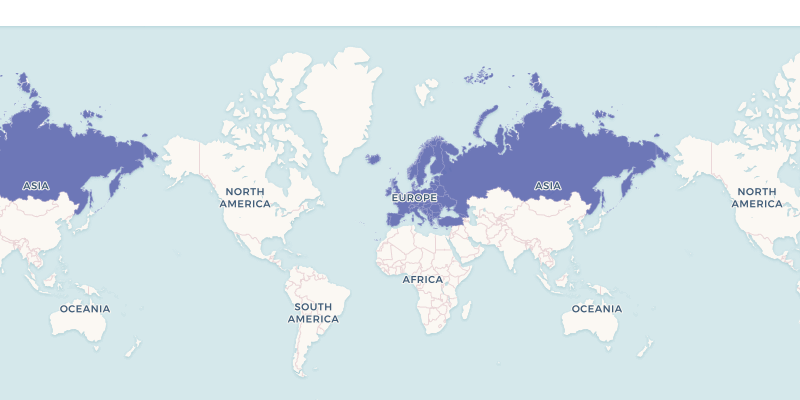

In [179]:
# cc.map takes a layers argument which specifies the data layers that are to be visualized. 
#   They can be imported from cartoframes as below.

import matplotlib.pyplot as plt

from cartoframes import Layer, styling, BaseMap
l = Layer('europe_names')

cc.map(layers=l,
       interactive=False)

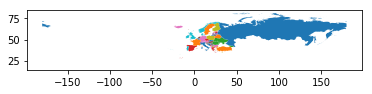

In [188]:
# geopandas
import geopandas as gpd

gdf = gpd.GeoDataFrame(df)
gdf.plot('cnt0', linewidth=0.1)

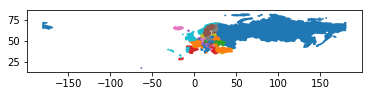

In [182]:
# you can use shapely geometric operations
gdf['geometry'] = gdf.geometry.apply(lambda x: x.buffer(1))
gdf.plot('cnt0', linewidth=0.1)

# now you can upload result table to CARTO as new table


In [14]:
# Use Data Observatory to add education data to the countries

meta = cc.data_discovery(region='europe_names', keywords='education')
meta


,denom_aggregate,denom_colname,denom_description,denom_geomref_colname,denom_id,denom_name,denom_reltype,denom_t_description,denom_tablename,denom_type,...,numer_timespan,numer_type,score,score_rank,score_rownum,suggested_name,target_area,target_geoms,timespan_rank,timespan_rownum
0,sum,t005c001_f,None,geo_code,ca.statcan.cols_nhs.t005c001_f,Total population aged 15+ (female),denominator,None,obs_287c200ba387d0ffbdd6ed392f3021ea6cf9f15c,Numeric,...,2011,Numeric,30.594575,1,1,t005c023_f_2011,None,None,1,1
1,sum,t005c001_f,None,geo_code,ca.statcan.cols_nhs.t005c001_f,Total population aged 15+ (female),denominator,None,obs_287c200ba387d0ffbdd6ed392f3021ea6cf9f15c,Numeric,...,2011,Numeric,30.594575,1,1,t005c023_f_2011_by_t005c001_f,None,None,1,1
2,sum,t005c001_m,None,geo_code,ca.statcan.cols_nhs.t005c001_m,Total population aged 15+ (male),denominator,None,obs_287c200ba387d0ffbdd6ed392f3021ea6cf9f15c,Numeric,...,2011,Numeric,30.594575,1,1,t005c023_m_2011,None,None,1,1
3,sum,t005c001_m,None,geo_code,ca.statcan.cols_nhs.t005c001_m,Total population aged 15+ (male),denominator,None,obs_287c200ba387d0ffbdd6ed392f3021ea6cf9f15c,Numeric,...,2011,Numeric,30.594575,1,1,t005c023_m_2011_by_t005c001_m,None,None,1,1
4,sum,t005c001_t,None,geo_code,ca.statcan.cols_nhs.t005c001_t,Total population aged 15+ (total),denominator,None,obs_287c200ba387d0ffbdd6ed392f3021ea6cf9f15c,Numeric,...,2011,Numeric,30.594575,1,1,t005c023_t_2011,None,None,1,1
5,sum,t005c001_t,None,geo_code,ca.statcan.cols_nhs.t005c001_t,Total population aged 15+ (total),denominator,None,obs_287c200ba387d0ffbdd6ed392f3021ea6cf9f15c,Numeric,...,2011,Numeric,30.594575,1,1,t005c023_t_2011_by_t005c001_t,None,None,1,1
6,sum,t014c003_f,None,geo_code,ca.statcan.cols_nhs.t014c003_f,Labour force aged 15+ - All industries (female),denominator,None,obs_4d439c7f0983df92f64a9da3e8c2a4c43be45ebb,Numeric,...,2011,Numeric,30.594575,1,1,t014c018_f_2011,None,None,1,1
7,sum,t014c003_f,None,geo_code,ca.statcan.cols_nhs.t014c003_f,Labour force aged 15+ - All industries (female),denominator,None,obs_4d439c7f0983df92f64a9da3e8c2a4c43be45ebb,Numeric,...,2011,Numeric,30.594575,1,1,t014c018_f_2011_by_t014c003_f,None,None,1,1
8,sum,t014c003_m,None,geo_code,ca.statcan.cols_nhs.t014c003_m,Labour force aged 15+ - All industries (male),denominator,None,obs_4d439c7f0983df92f64a9da3e8c2a4c43be45ebb,Numeric,...,2011,Numeric,30.594575,1,1,t014c018_m_2011,None,None,1,1
9,sum,t014c003_m,None,geo_code,ca.statcan.cols_nhs.t014c003_m,Labour force aged 15+ - All industries (male),denominator,None,obs_4d439c7f0983df92f64a9da3e8c2a4c43be45ebb,Numeric,...,2011,Numeric,30.594575,1,1,t014c018_m_2011_by_t014c003_m,None,None,1,1
